In [1]:
import imutils.perspective
from matplotlib import pyplot as plt
from easyocr import Reader
import random
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [3]:
langs = ['ko', 'en']
# langs = ['ko']

original_img = cv2.imread('./img/ocr_pre.jpg', cv2.COLOR_BGR2GRAY)
# original_img = cv2.imread('./img/ocr_charcter.png')

reader = Reader(lang_list=langs)
results = reader.readtext(original_img, detail=1)

results

# hos_list = ['동물병원', '가축병원', '동물의료센터', '수의과', '동물구조센터', '출장진료전문', '동물의료원', '가금진료', '동물메디컬센터', '동물메디컬클리닉', '동물외과']
# hos_name = ''
# table = {}
# for hos in hos_list:
#     for result in results:
#         if result.find(hos) != -1:
#             table['hos_name'] = result
#             hos_name = result
#             break

# if hos_name == '':
#     print('동물병원 영수증이 아닙니다.')
# else:
#     print(table)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


ValueError: Invalid input type. Supporting format = string(file path or url), bytes, numpy array

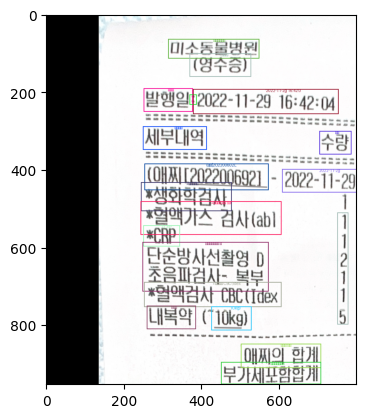

In [ ]:
reader = Reader(['ko','en']) # need to run only once to load model into memory
result = reader.readtext('./img/ocr_charcter.png')

img    = cv2.imread('./img/ocr_charcter.png')

img = Image.fromarray(img)
# font = ImageFont.truetype("fonts/HMKMRHD.TTF",20)
draw = ImageDraw.Draw(img)

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")


for i in result :
    x = i[0][0][0]
    y = i[0][0][1]
    w = i[0][1][0] - i[0][0][0]
    h = i[0][2][1] - i[0][1][1]
    
    color_idx = random.randint(0,255)
    color = [int(c) for c in COLORS[color_idx]]
    
#    cv2.putText(img, str(i[1]), (int((x + x + w) / 2) , y-2), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
#    img = cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
    draw.text((int((x + x + w) / 2) , y-2),str(i[1]), fill=tuple(color),)

plt.imshow(img)
plt.show()

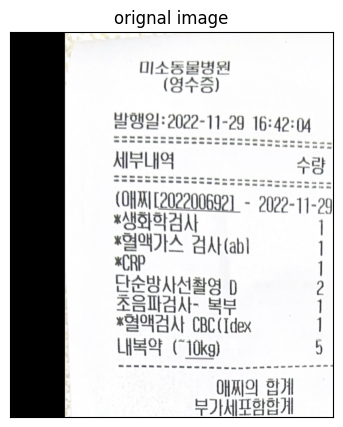

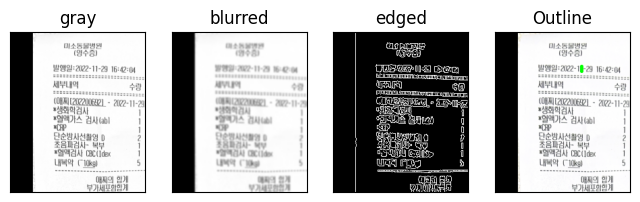

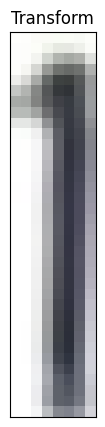

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...


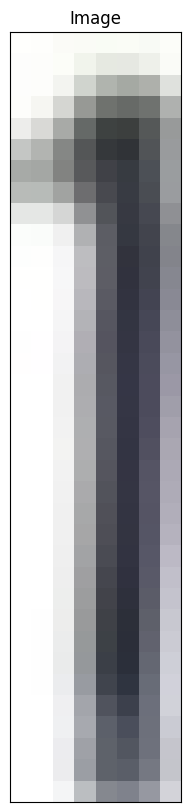

In [ ]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
    image_list_title = []
    image_list = []
    
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    # 이미지를 grayscale로 변환하고 blur를 적용
    # 모서리를 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)
    
    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]
    
    # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    findCnt = None

    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
        if len(approx) == 4:
            findCnt = approx
            break


    # 만약 추출한 윤곽이 없을 경우 오류
    if findCnt is None:
        raise Exception(("Could not find outline."))

    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)

    image_list_title.append("Outline")
    image_list.append(output)

# 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform", transform_image)

    return transform_image

def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=2):
    # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
    # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
    img = Image.fromarray(cv_img)
    
    draw = ImageDraw.Draw(img)
    draw.text((x, y), text, fill=color)

    cv_img = np.array(img)

    return cv_img  

org_image = cv2.imread('./img/ocr_charcter.png', cv2.COLOR_BGR2GRAY)
plt_imshow("orignal image", org_image)

ticket1_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=False)
results = reader.readtext(ticket1_image)
# loop over the results
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))

    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

	# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
    cv2.rectangle(ticket1_image, tl, br, (0, 255, 0), 2)
    ticket1_image = putText(ticket1_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
	# cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
plt_imshow("Image", ticket1_image, figsize=(16,10))